In [1]:
import numpy as np
import torch
import utility.dataset as dataset
from utility.preprocessing import preprocessing
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

/Users/alberty/miniforge3/envs/hlagent/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
global_models = []
local_results = []
global_results = []
tasks_data_info = []
tasks_data_idx = []
type_iid=["noniid"]
task_type = ["mnist"]
num_clients = 20
class_ratio=[0.21]
class ARGS:
    def __init__(self):
        global num_clients
        self.num_clients = num_clients
        self.unbalance = [1.0, 1.0]

args = ARGS()
for i in range(len(task_type)):
    tasks_data_info.append(preprocessing(task_type[i], data_ratio=1.0, args=args)) # 0: trainset, 1: testset, 2: min_data_num, 3: max_data_num 4: input_size, 5: classes_size
    if type_iid[i] =='iid':
        tasks_data_idx.append(dataset.iid(dataset=tasks_data_info[i][0],
                                        min_data_num=tasks_data_info[i][2],
                                        max_data_num=tasks_data_info[i][3],
                                        num_users=num_clients)) # 0: clients_data_idx
    elif type_iid[i] =='noniid':
        tasks_data_idx.append(dataset.noniid(dataset=tasks_data_info[i][0],
                            min_data_num=tasks_data_info[i][2],
                            max_data_num=tasks_data_info[i][3],
                            class_ratio=class_ratio[i],
                            num_users=num_clients)) # 0: clients_data_idx 1: clients_label
    #global_models.append(load_model(name_data=task_type[i], num_classes=tasks_data_info[i][5], args=args).to(device))
    #local_results.append([-1,-1])
    #global_results.append([-1,-1])
    
#tasks_data_idx = np.array(tasks_data_idx)
#print(tasks_data_idx[:, :, 0])

100%|██████████| 9912422/9912422 [00:00<00:00, 23715795.93it/s]


Extracting ./utility/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./utility/dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63722090.39it/s]

Extracting ./utility/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./utility/dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23016222.09it/s]


Extracting ./utility/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./utility/dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13084154.37it/s]
/Users/alberty/Desktop/18786/FL-cluster-sampling/utility/dataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


Extracting ./utility/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./utility/dataset/MNIST/raw



In [3]:
class MnistMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistMLP, self).__init__()
        self.in_size = 28 * 28
        self.hidden_size = 100
        self.out_size = num_classes
        self.net = nn.Sequential(
            nn.Linear(in_features=self.in_size, out_features=self.hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
        )
        for m in self.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_normal_(m.weight)

    def forward(self, batch):
        batch = batch.view(batch.size(0),-1)
        return torch.squeeze(self.net(batch))

In [4]:
class Client:
    def __init__(self, client_index, batch_size=128, tasks_index=0):
        global tasks_data_info, tasks_data_idx
        self.client_index = client_index
        self.tasks_data_info = tasks_data_info
        self.tasks_data_idx = tasks_data_idx
        self.batch_size = batch_size
        self.tasks_index = tasks_index # 0 is non-iid
        self.set_data()
        
        self.model = MnistMLP()
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.training()
        print(f"Client {client_index}; labels {self.non_iid_labels}; accuracy {np.round(self.get_training_accuracy(), 3)}")
        self.get_trained_weights()
        
    def set_data(self):
        if type_iid[self.tasks_index] == 'iid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][self.client_index])  # or iid_partition depending on your choice
        elif type_iid[self.tasks_index] == 'noniid':
            client_data = Subset(self.tasks_data_info[self.tasks_index][0], 
                                 self.tasks_data_idx[self.tasks_index][0][self.client_index])  # or iid_partition depending on your choice
            self.non_iid_labels = self.tasks_data_idx[self.tasks_index][1][self.client_index]
        self.loader = DataLoader(client_data, batch_size=self.batch_size, shuffle=True)
    
    
    def training(self, epochs=10):
        loader = self.loader
        self.model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        for _ in range(epochs):
            self.model.train()
            loss = 0
            for i, (data, target) in enumerate(loader):
                optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss += loss.item()
        return self.model
    
    def get_training_accuracy(self):
        self.model.to(self.device)
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        return correct / total
    
    def get_trained_weights(self):
        # get weights
        self.weights = []
        for param in self.model.parameters():
            self.weights.append(param.data.cpu().numpy())
        self.flattened_weights = np.concatenate([w.flatten() for w in self.weights])
        # get graidents
        self.gradients = []
        for p in self.model.parameters():
            self.gradients.append(p.grad.data.cpu().numpy())
        self.flattened_gradients = np.concatenate([g.flatten() for g in self.gradients])
        # get gradident norms
        self.gradient_norms = [np.linalg.norm(g) for g in self.gradients]

In [5]:
class Cluster:
    def __init__(self, clients, num_clusters=5):
        self.clients = clients
        self.num_clusters = num_clusters
        self.cluster()
        
    def cluster(self, method="gradient_norm"):
        #self.client_weights = np.array([c.flattened_weights for c in self.clients])
        #self.client_gradients = np.array([c.flattened_gradients for c in self.clients])
        self.client_norms = np.array([c.gradient_norms for c in self.clients])
        self.data = self.client_norms
        
        self.pca = PCA(n_components=2)
        self.client_pca = self.pca.fit_transform(self.data)
        self.kmeans = KMeans(n_clusters=self.num_clusters)
        self.kmeans.fit(self.client_pca)
        self.cluster_labels = self.kmeans.labels_
        self.cluster_centers = self.kmeans.cluster_centers_
        self.plot()
        
    def plot(self):
        plt.figure(figsize=(10, 10))
        for i in range(self.num_clusters):
            plt.scatter(self.client_pca[self.cluster_labels == i, 0], 
                        self.client_pca[self.cluster_labels == i, 1], 
                        label=f'Cluster {i}')
        for i, (x, y) in enumerate(self.client_pca):
            plt.annotate(f'Client {i}; labels {self.clients[i].non_iid_labels}', 
                         (x, y), 
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center')
        plt.legend()
        plt.show()
    
    def get_result(self):
        return pd.DataFrame({"cluster_labels": self.cluster_labels, 
                             "client_index": [c.client_index for c in self.clients]})

Client 0; labels [1, 7]; accuracy 0.986
Client 1; labels [1, 3]; accuracy 0.988
Client 2; labels [1, 7]; accuracy 0.987
Client 3; labels [2, 9]; accuracy 0.996
Client 4; labels [0, 6]; accuracy 0.995
Client 5; labels [1, 8]; accuracy 0.981
Client 6; labels [4, 3]; accuracy 0.998
Client 7; labels [7, 2]; accuracy 0.992
Client 8; labels [9, 0]; accuracy 0.996
Client 9; labels [6, 1]; accuracy 1.0
Client 10; labels [4, 8]; accuracy 0.996
Client 11; labels [3, 7]; accuracy 0.982
Client 12; labels [2, 5]; accuracy 0.986
Client 13; labels [9, 0]; accuracy 0.998
Client 14; labels [6, 1]; accuracy 1.0
Client 15; labels [4, 8]; accuracy 0.994
Client 16; labels [3, 7]; accuracy 0.996
Client 17; labels [2, 5]; accuracy 0.996
Client 18; labels [9, 6]; accuracy 1.0
Client 19; labels [1, 0]; accuracy 1.0


/Users/alberty/miniforge3/envs/hlagent/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


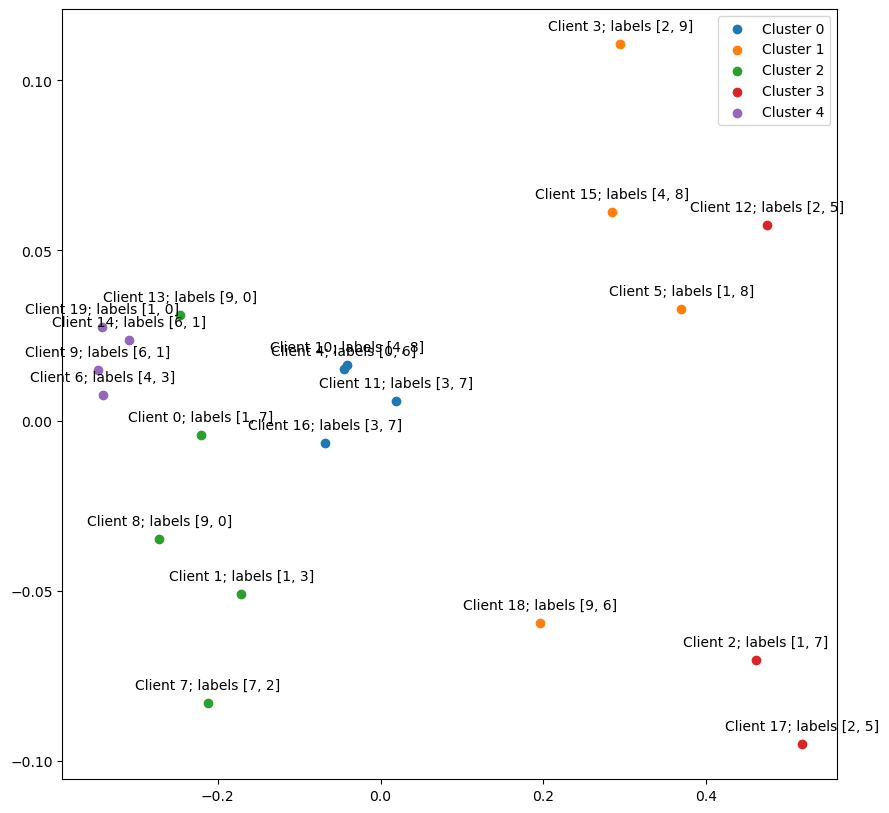

In [6]:
clients = [Client(i) for i in range(num_clients)]
c = Cluster(clients)